## 在这个 Notebook 里，我们要分别尝试用分类跟分群的方式，试图把不同类型的鸢尾花区分出来


* 会使用上许多套件，不必全部理解，了解整体编程的逻辑及概念即可！
* 资料前处理 -> 视觉化探索 -> 建立模型 -> 验证

In [1]:
## 基础运算套件
import pandas as pd
import numpy as np

## 各种机器学习模型套件
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC

## 训练模型工具套件
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import datasets, model_selection
from sklearn.decomposition import PCA

## 可视化套件
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 首先透过 sklearn 的 datasets 套件取得资料集

* 可参考： https://scikit-learn.org/stable/datasets/index.html


<img src="./img/sklearn_dataset.png" alt="drawing" style="width:800px; float: left;"/>

In [2]:
iris = datasets.load_iris()

## 在预设资料集里，训练资料及答案都已经准备好了
X = iris.data
y = iris.target
names = iris['feature_names']

print('(资料笔数, 特征数目)：',X.shape)
print('答案笔数：',y.shape[0])
print('特征名称：',names)

(资料笔数, 特征数目)： (150, 4)
答案笔数： 150
特征名称： ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### 先取其中两个栏位出来看看

> 用视觉化检查属性的数值，是否对于分类有鉴别性


### [思考一下] 从这张图表，你发现了什么呢？

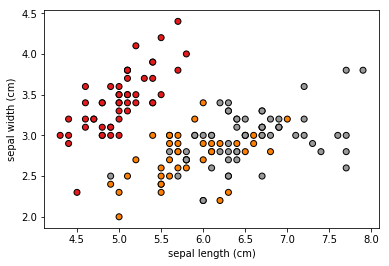

In [3]:
## 任意挑选两个属性来做比对分析
feature_index = [0, 1]

X = iris.data[:, feature_index]  
y = iris.target

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')

plt.xlabel(names[feature_index[0]])
plt.ylabel(names[feature_index[1]])
plt.show()

### [试试看] 你能找到辨识度最高的特征组合吗？

In [ ]:
feature_index = [_, _]

X = iris.data[:, feature_index]  
y = iris.target


plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')

plt.xlabel(names[feature_index[0]])
plt.ylabel(names[feature_index[1]])
plt.show()

### seaborn：更强的视觉套件

In [5]:
## 先做一些前处理

iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                       columns= iris['feature_names'] + ['target'])

def get_species(index):
    return iris.target_names[int(index)]


iris_df['species'] = iris_df['target'].map(lambda x: get_species(x))

In [6]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0.0,setosa
1,4.9,3.0,1.4,0.2,0.0,setosa
2,4.7,3.2,1.3,0.2,0.0,setosa
3,4.6,3.1,1.5,0.2,0.0,setosa
4,5.0,3.6,1.4,0.2,0.0,setosa


### 对于资料特征的分布，更一目了然了！

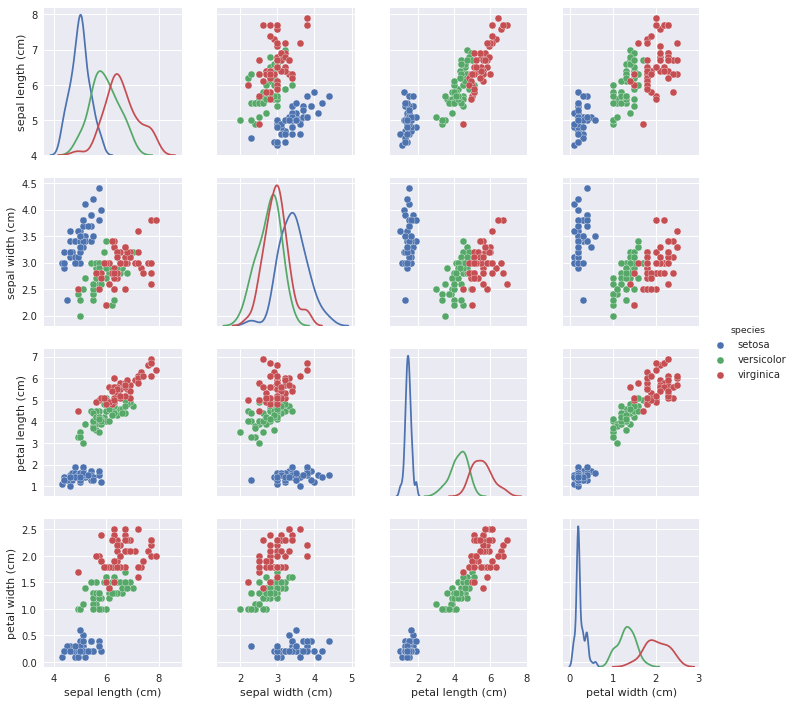

In [7]:
sns.set()
sns.pairplot(iris_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']],
             hue="species", diag_kind="kde")

### 当特征的数量超过3个，又想在不筛选特征的情形下做视觉化

> 降维也是一个分析资料很快速的方式！

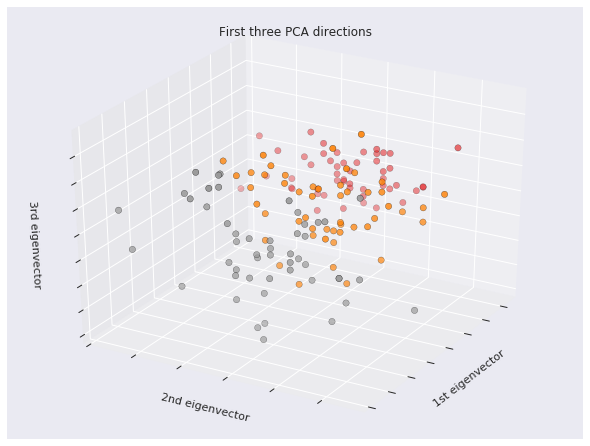

In [8]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=150)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

### 训练分类模型

1. 切分训练及测试集
2. 透过 sklearn 选择想训练的模型类别
3. corss-validation 检视资料结果
4. 在测试集上做验证
5. 伪造几笔资料看看

In [9]:
X_train, X_test, y_train, y_test = \
    train_test_split(iris.data, iris.target, test_size=0.3)

In [10]:
# 定义多个模型
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# 实测结果并印出
predictor = {}
for name, model in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    predictor[name] = model.fit(X_train, y_train)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

LR: 0.923810 (0.057143)
KNN: 0.971429 (0.023328)
CART: 0.952381 (0.030117)
NB: 0.933333 (0.023328)
SVM: 0.961905 (0.019048)


### 重要的一步：在没看过的资料里，也要有稳定表现才行

[思考一下] 如果在训练集表现很好，测试集表现却很差，可能的原因？

In [11]:
y_pred = predictor['SVM'].predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9555555555555556


### 从这个图表可以看出：

* Sepal 宽度大的时候，是 setosa 的机率很高
* Petal 长度大的时候，是 virginica 的机率很高 


<img src="./img/iris_plot.png" alt="drawing" style="width:800px; float: left;"/>

**已知平均为：**

* sepal length：5.843333
* sepal width：3.057333
* petal length：3.758000
* petal width：1.199333

手工伪造几笔资料：

* [5.843333, `4.557333`, 3.758000, 1.199333]
* [5.843333, 3.057333, `7.758000`, 1.199333]
* [5.843333, 3.057333, 3.758000, 1.199333]


In [12]:
iris_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}


print(iris_map[predictor['SVM'].predict([[5.843333, 4.557333, 3.758000, 1.199333]])[0]])

print(iris_map[predictor['SVM'].predict([[5.843333, 3.057333, 7.758000, 1.199333]])[0]])

print(iris_map[predictor['SVM'].predict([[5.843333, 3.057333, 3.758000, 1.199333]])[0]])

versicolor
virginica
versicolor


### [思考一下] 这样子的资料集，适合套用聚类方法吗？

In [13]:
feature_index = [0, 2]

X = iris.data[:, feature_index]  
y = iris.target

In [14]:
km = KMeans(n_clusters = 3, n_jobs = 4, random_state=21)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=4, precompute_distances='auto',
    random_state=21, tol=0.0001, verbose=0)

### 印出三个群的中心点

In [15]:
centers = km.cluster_centers_
print(centers)

[[5.87413793 4.39310345]
 [5.00784314 1.49215686]
 [6.83902439 5.67804878]]


### 比较分群结果与真实类别分布

Text(0.5, 1.0, 'Predicted')

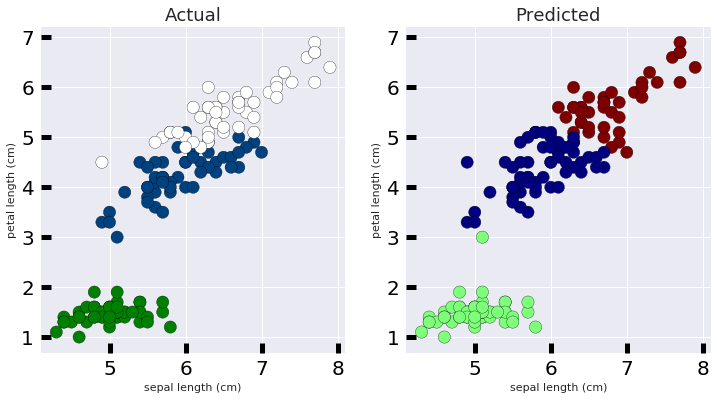

In [16]:
new_labels = km.labels_
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap='ocean', edgecolor='k', s=150)
axes[1].scatter(X[:, 0], X[:, 1], c=new_labels, cmap='jet', edgecolor='k', s=150)

axes[0].set_xlabel(names[feature_index[0]])
axes[0].set_ylabel(names[feature_index[1]])
axes[1].set_xlabel(names[feature_index[0]])
axes[1].set_ylabel(names[feature_index[1]])

axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)

axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('Predicted', fontsize=18)

## [试试看]


- 当用哪两个属性做分群，效果感觉最好呢？
- 如果分成四群或是五群或是更多，分群成果好坏如何？
- 进阶题：把四个属性做降维成两维，在做分群，看看成果